# Lab 5: Spam Detection

**Deadline**: Thursday, July 9, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Baiwu (Chris) Zhang  

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
counter = 0
for line in open('/content/drive/My Drive/Colab Notebooks/SMSSpamCollection'):
  if (line[0] == "h" and counter == 0):
    counter += 1
    print(line)
  elif (line[0] == "s" and counter == 1):
    counter += 1
    print(line)

  if (counter > 2):
    break

#spam = spam
#non spam = ham

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam_c = 0
ham_c = 0
for line in open('/content/drive/My Drive/Colab Notebooks/SMSSpamCollection'):
  if (line[0] == "h"):
    ham_c += 1
  else:
    spam_c += 1

print("SPAM:", spam_c)
print("HAM:", ham_c)

SPAM: 747
HAM: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
#Advantages of using characters rather than words:
#There are thousands of words in a vocabulary - storing each word representation is costly (memory)
#Many spam messages have recurring characters that may be easy to identify

#Disadvantage to using character rather than words:
#Does not understand the context of word -> word
#higher computational cost for char based embeddings

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/content/drive/My Drive/Colab Notebooks/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

#balanced training set -> model has equal experience in recognizing spam and no spam
#parameters will not be tuned to only revognize a certain type of message

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

#stoi -> mapping token strings to numerical identifiers.
#itos -> A list of token strings indexed by their numerical identifiers

defaultdict(<function _default_unk_index at 0x7f88cb4e79d8>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'v': 30, '5': 31, 'E': 32, 'S': 33, 'C': 34, 'I': 35, 'O': 36, '4': 37, 'x': 38, 'N': 39, '3': 40, '6': 41, 'A': 42, '7': 43, '!': 44, 'R': 45, ',': 46, 'P': 47, '9': 48, 'W': 49, 'M': 50, 'U': 51, 'H': 52, 'L': 53, 'D': 54, 'B': 55, "'": 56, 'G': 57, '/': 58, 'F': 59, 'Y': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'z': 66, 'V': 67, 'X': 68, 'j': 69, 'K': 70, '*': 71, 'J': 72, ')': 73, ';': 74, '+': 75, 'q': 76, '(': 77, 'Q': 78, '#': 79, '"': 80, '=': 81, '@': 82, 'Z': 83, '>': 84, 'ü': 85, '_': 86, 'Ü': 87, '<': 88, '$': 89, '%': 90, '\x92': 91, '|': 92, '‘': 93, '[': 94, ']': 95, '\x93': 96, '’': 97, '“': 98, '…': 99, 'é': 100, '\\': 101, '~': 102, '\x

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
#<unk> -> out-of-vocabulary words
#<pad> -> padding

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
counter = 0
for batch in train_iter:
  counter += 1
  #print(batch.sms[1])
  maxm = torch.max(batch.sms[1]).item()
  padding_total = 0
  for item in batch.sms[1]: 
    padding_total += (maxm - item.item())
  print(padding_total)
  if (counter == 10):
    break
  

32
26
4
0
53
62
44
28
35
48


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
#print(ident[0]) # one-hot vector
#print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
##### SAMPLE CODE #############################################################

# RNN Architecture
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

###############################################################################

In [ ]:
##### SAMPLE CODE #############################################################

# RNN Architecture
class SpamRNN_Another(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN_Another, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
    output = self.fc(output)
    return output

###############################################################################

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
##### SAMPLE CODE #############################################################
def get_accuracy(model, data, batch_size = 32):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.sms), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total = 0, 0
    for batch in data_iter:
      output = model(batch.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(batch.label.view_as(pred)).sum().item()
      total += batch.sms[1].shape[0]
    return correct / total

###############################################################################

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def get_valid_acc(valid, model):
  criterion = nn.CrossEntropyLoss()
  for batch in valid:
    pred = model(batch.sms[0])
    loss = criterion(pred, batch.label)
  return float(loss)

epoch:  0 train acc:  0.5881391929423296 val acc:  0.874439461883408
epoch:  1 train acc:  0.7363175951641888 val acc:  0.4789237668161435
epoch:  2 train acc:  0.6175461525894461 val acc:  0.2807174887892377
epoch:  3 train acc:  0.678157163862114 val acc:  0.36771300448430494
epoch:  4 train acc:  0.7198170233621958 val acc:  0.4538116591928251
epoch:  5 train acc:  0.9163535370037575 val acc:  0.8475336322869955
epoch:  6 train acc:  0.9400424767194903 val acc:  0.9318385650224216
epoch:  7 train acc:  0.9339977127920275 val acc:  0.9426008968609866
epoch:  8 train acc:  0.9289331808528019 val acc:  0.947085201793722
epoch:  9 train acc:  0.9251756248978925 val acc:  0.95695067264574
epoch:  10 train acc:  0.932037248815553 val acc:  0.9560538116591928
epoch:  11 train acc:  0.9255023688939715 val acc:  0.9721973094170404
epoch:  12 train acc:  0.9390622447312531 val acc:  0.9614349775784753
epoch:  13 train acc:  0.9410227087077275 val acc:  0.9695067264573991
epoch:  14 train acc:

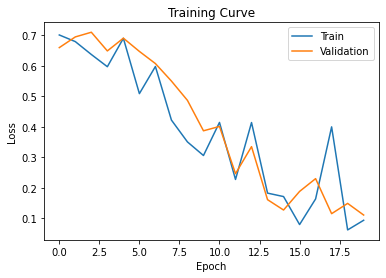

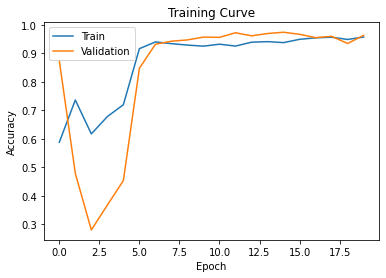

In [ ]:
############### INCOMPLETE SAMPLE CODE #########################################
import matplotlib.pyplot as plt
def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loader = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  valid_loader = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  losses, train_acc, valid_acc = [], [], []
  epochs = []
  valid_losses = []

  for epoch in range(num_epochs):
      for batch in train_loader:
        optimizer.zero_grad()
        #print(batch.sms[0])
        pred = model(batch.sms[0])
        loss = criterion(pred, batch.label)
        loss.backward()
        optimizer.step()
      losses.append(float(loss))
      valid_losses.append(get_valid_acc(valid=valid_loader, model=model))
      epochs.append(epoch)
      train_acc.append(get_accuracy(model, train))
      valid_acc.append(get_accuracy(model, valid))

      print("epoch: ", epoch, end = " ")
      print("train acc: ", get_accuracy(model, train), end = " ")
      print("val acc: ", get_accuracy(model, valid))
  
  plt.title("Training Curve")
  plt.plot(losses, label="Train")
  plt.plot(valid_losses, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)
############### INCOMPLETE SAMPLE CODE ######################################### 

epoch:  0 train acc:  0.5917333768991995 val acc:  0.22869955156950672
epoch:  1 train acc:  0.5549746773403039 val acc:  0.16143497757847533
epoch:  2 train acc:  0.6972716876327397 val acc:  0.44035874439461886
epoch:  3 train acc:  0.9240320209116157 val acc:  0.9399103139013453
epoch:  4 train acc:  0.9181506289821925 val acc:  0.9408071748878923
epoch:  5 train acc:  0.9322006208135926 val acc:  0.9443946188340807
epoch:  6 train acc:  0.9317105048194739 val acc:  0.9094170403587444
epoch:  7 train acc:  0.9477209606273485 val acc:  0.947085201793722
epoch:  8 train acc:  0.9472308446332298 val acc:  0.9417040358744395
epoch:  9 train acc:  0.9493546806077439 val acc:  0.9399103139013453
epoch:  10 train acc:  0.9388988727332135 val acc:  0.9139013452914798
epoch:  11 train acc:  0.9524587485704951 val acc:  0.9452914798206278
epoch:  12 train acc:  0.9518052605783369 val acc:  0.9434977578475336
epoch:  13 train acc:  0.9491913086097042 val acc:  0.9345291479820628
epoch:  14 tra

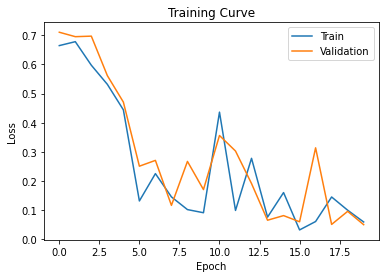

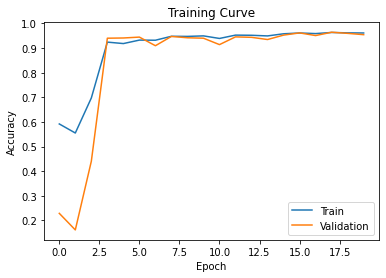

In [ ]:
model_2 = SpamRNN_Another(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_2, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

epoch:  0 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  1 train acc:  0.6132984806404183 val acc:  0.284304932735426
epoch:  2 train acc:  0.92958666884496 val acc:  0.9533632286995516
epoch:  3 train acc:  0.9292599248488809 val acc:  0.9668161434977578
epoch:  4 train acc:  0.9462506126449927 val acc:  0.9542600896860987
epoch:  5 train acc:  0.9477209606273485 val acc:  0.9704035874439462
epoch:  6 train acc:  0.9558895605293253 val acc:  0.957847533632287
epoch:  7 train acc:  0.9565430485214834 val acc:  0.9641255605381166
epoch:  8 train acc:  0.9553994445352066 val acc:  0.9721973094170404
epoch:  9 train acc:  0.9611174644665904 val acc:  0.9695067264573991
epoch:  10 train acc:  0.9482110766214671 val acc:  0.9713004484304932
epoch:  11 train acc:  0.9601372324783533 val acc:  0.9713004484304932
epoch:  12 train acc:  0.9648750204214998 val acc:  0.9668161434977578
epoch:  13 train acc:  0.9650383924195393 val acc:  0.9704035874439462
epoch:  14 train ac

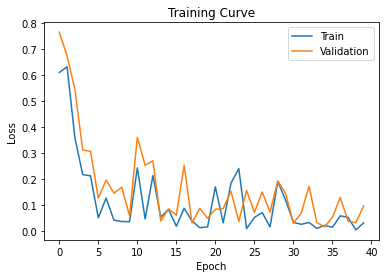

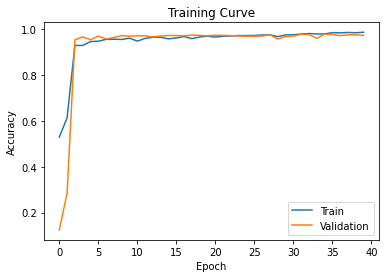

In [ ]:
model_3 = SpamRNN(input_size=len(text_field.vocab), hidden_size=40, num_classes=2)
train_rnn_network(model_3, train, valid, batch_size=32, num_epochs=40, learning_rate=1e-4)

epoch:  0 train acc:  0.7033164515602026 val acc:  0.4744394618834081
epoch:  1 train acc:  0.7551053749387355 val acc:  0.5542600896860986
epoch:  2 train acc:  0.9246855089037739 val acc:  0.9560538116591928
epoch:  3 train acc:  0.9117791210586506 val acc:  0.9587443946188341
epoch:  4 train acc:  0.9356314327724228 val acc:  0.9560538116591928
epoch:  5 train acc:  0.943309916680281 val acc:  0.9381165919282511
epoch:  6 train acc:  0.9488645646136252 val acc:  0.9605381165919282
epoch:  7 train acc:  0.950334912595981 val acc:  0.957847533632287
epoch:  8 train acc:  0.9529488645646136 val acc:  0.9542600896860987
epoch:  9 train acc:  0.954909328541088 val acc:  0.9704035874439462
epoch:  10 train acc:  0.9563796765234439 val acc:  0.9641255605381166
epoch:  11 train acc:  0.9589936284920765 val acc:  0.9721973094170404
epoch:  12 train acc:  0.9606273484724718 val acc:  0.9659192825112107
epoch:  13 train acc:  0.9603006044763928 val acc:  0.9623318385650225
epoch:  14 train acc

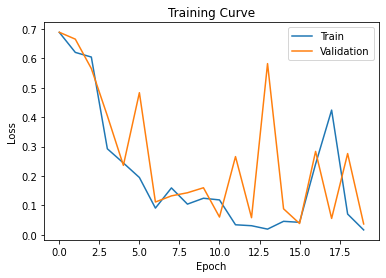

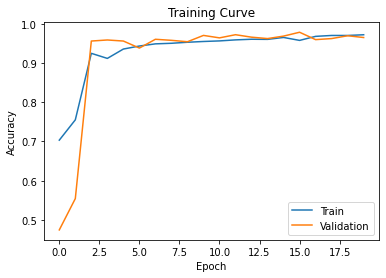

In [ ]:
model_4 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_4, train, valid, batch_size=16, num_epochs=20, learning_rate=1e-4)

epoch:  0 train acc:  0.5296520176441758 val acc:  0.12466367713004484
epoch:  1 train acc:  0.5296520176441758 val acc:  0.12466367713004484
epoch:  2 train acc:  0.5296520176441758 val acc:  0.12466367713004484
epoch:  3 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  4 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  5 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  6 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  7 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  8 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  9 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  10 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  11 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  12 train acc:  0.5294886456461363 val acc:  0.12466367713004484
epoch:  13 train acc:  0.5294886456461363 val acc:  0.12466367713004484
ep

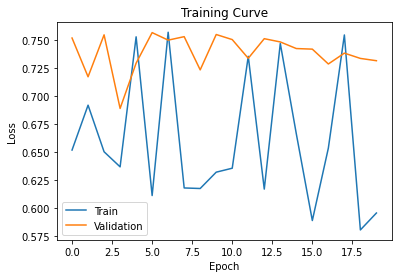

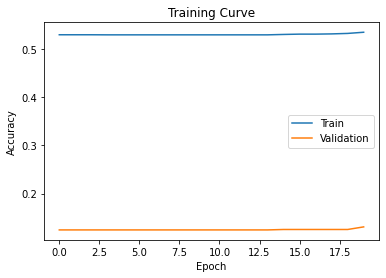

In [ ]:
model_5 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_5, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-5)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
#Hyperparameter 1: Batch size
#Decreased batch size so that parameters would be updated more frequently, so that they may be more accurate
#Since runtime is fairly quick, decreasing batch size is ok
#Accuracy:

#Hyperparameter 2: Learning rate
#Lower learning rate
#since we are able to coverge quickly to a high accuracy, we might want to move slower to see if we can get to 
#a local minimum without overshooting
#Accuracy:

#Hyperparameter 3: Hidden size
#Increase hidden size so that there are more parameters
#Might be able to capture more information
#Accuracy:

#Hyperparameter 4: Max pool/Avg pool
#Using this method to try and increase accuracy
#Accuracy:

#Hyperparameter 5: Number of epochs
#Results get better the more it is run
#Accuracy:

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [ ]:
false_pos = 1-get_accuracy(model_1, valid_spam)
false_neg = 1-get_accuracy(model_1, valid_nospam)
print("false pos:", false_pos)
print("false neg:", false_neg)

false pos: 0.02877697841726623
false neg: 0.03688524590163933


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
#False positive -> spam being labeled as non-spam -> fairly harmless
#False negative -> non-spam labeled as spam -> harmful - you may miss important emails because they were labeled as spam

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_acc = get_accuracy(model_3, test)
print(test_acc)

0.9694793536804309


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

In [ ]:
false_pos_t = 1-get_accuracy(model_3, test_spam)
false_neg_t = 1-get_accuracy(model_3, test_nospam)
print("false pos:", false_pos_t)
print("false neg:", false_neg_t)

false pos: 0.04137931034482756
false neg: 0.029927760577915352


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

In [ ]:
some_tens = []

for letters in msg:
  some_tens.append(text_field.vocab.stoi[letters])

print(some_tens)
#text_field.vocab.itos

[18, 6, 17, 13, 9, 7, 3, 2, 11, 3, 6, 8, 7, 9, 7, 22, 2, 9, 10, 2, 10, 4, 4, 4, 2, 17, 4, 4, 11, 44]


In [ ]:
some_tens = [ some_tens ]

final_ans = model_3(some_tens)
final_ans = torch.nn.functional.softmax(final_ans, dim=1)

In [ ]:
print("Probability of being spam:")
print(float(final_ans[0][1])*100)
print("%")

Probability of being spam:
1.159009337425232
%


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
#Baseline model can be a combination of heuristics and previous data
#Baseline would compare what user marked as spam with unread email
#Given a similarity score >75%, mark it as spam
#Also use heuristics -> spam emails have hyperlinks, weird spellings and unknown addresses.
#Using the information above, calculate a probability that the email is spam.